## CCNSS 2018 Module 1: Neurons, synapses and networks
# Tutorial 2: Eigenvalues and stability
[source](https://colab.research.google.com/drive/1AjAsADoPZXHw4HDkmYMCjQbeuNujKtol)

Please execute the cell below to initialise the notebook environment.

In [1]:
%autosave 0

import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import random                      # import basic random number generator functions
import scipy.optimize as opt       # import root-finding algorithm

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

Autosave disabled



## Objectives
In this notebook, we return to the Wilson-Cowan equations and learn about eigenvalues and stability. First execute the cell below to initialise the simulation parameters.

**Background paper:**
*  Wilson H and Cowan J (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophysical Journal 12.

In [2]:
dt = 0.1

# Connection weights
wEE = 12
wEI = 4
wIE = 13
wII = 11

# Refractory parameter
r = 1

# External input
I_ext = 0

# Excitatory parameters
tau_E = 1       # Timescale of excitatory population
a_E = 1.2       # Gain of excitatory population
theta_E = 2.8   # Threshold of excitatory population

# Inhibitory parameters
tau_I = 1       # Timescale of inhibitory population
a_I = 1         # Gain of inhibitory population
theta_I = 4     # Threshold of inhibitory population

Recall from Tutorial 1 that the Wilson-Cowan equations are given by:

\begin{align}
& \frac{dE}{dt} = -E + (1 - r E) F(w_{EE}E -w_{EI}I + I_{ext};a,\theta)\\
& \frac{dI}{dt} = -I + (1 - r I) F(w_{IE}E -w_{II}I;a,\theta)
\end{align}

Note that, in the cell above, we set $\tau_E = \tau_I = 1$, so we have dropped the timescales from the equations above. Let's now define the right-hand side of the equation using the functions $G_E(E,I)$ and $G_I(E,I)$:

\begin{align}
&\frac{dE}{dt} =G_E(E,I)\\
&\frac{dI}{dt} = G_I(E,I)
\end{align}

Previously, we studied a bifurcation in the Wilson-Cowan equations in which the system changed from one stable steady state to two (bistability). In this tutorial, we will use linear stability analysis to analyse the stability of the fixed points during this bifurcation. We will need to borrow some functions from the previous tutorial to simulate the equations, as well as to plot the E and I nullclines.

Execute the cell below to define the relevant functions (you may also copy paste the ones you have already created).

In [3]:
def F(x,a,theta): 
    """Population activation function.

    Arguments:
    x -- the population input
    a -- the gain of the function
    theta -- the threshold of the function
    
    Returns:
    y -- the population activation response
    """
    
    y = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1
    
    return y

  
def simulate_wc(t,E0,I0):
    """Simulate the Wilson-Cowan equations.
   
    Arguments:
    t -- time (vector)
    E0 -- initial condition of the excitatory population
    I0 -- initial condition of the inhibitory population
    
    Returns:
    E -- Activity of excitatory population (vector)
    I -- Activity of inhibitory population (vector)
    """
    
    dt = t[1]-t[0]
    E = np.zeros(len(t))
    I = np.zeros(len(t))
    E[0] = E0
    I[0] = I0
    for k in range(len(t)-1):
        E[k+1] = E[k] + dt/tau_E * (-E[k]+(1-r*E[k])*F(wEE*E[k]-wEI*I[k]+I_ext,a_E,theta_E))
        I[k+1] = I[k] + dt/tau_I * (-I[k]+(1-r*I[k])*F(wIE*E[k]-wII*I[k],a_I,theta_I))
        
    return E,I


def F_inv(x,a,theta): 
    """Define the inverse of the population activation function.

    Arguments:
    x -- the population input
    a -- the gain of the function
    theta -- the threshold of the function
    
    Returns:
    y -- value of the inverse function
    """
    
    y = -1/a * np.log((x+(1+np.exp(a*theta))**-1)**-1 -1) + theta
    
    return y


def get_E_nullcline(E):
    """Solve for I along the E nullcline (dE/dt = 0).
   
    Arguments:
    E -- values of E over which the nullcline is computed
    
    Returns:
    I -- values of I along the nullcline for each E
    """
    Ixv = 1./wEI*(wEE*E+I_ext-F_inv(E/(1-r*E),a_E,theta_E))
    
    return Ixv


def get_I_nullcline(I):
    """Solve for E along the I nullcline (dI/dt = 0).
   
    Arguments:
    I -- values of I over which the nullcline is computed
    
    Returns:
    E -- values of E along the nullcline for each I
    """
    Exv = 1./wIE*(wII*I+F_inv(I/(1-r*I),a_I,theta_I))
    
    return Exv





**Exercise 1:**  To find the exact fixed points of the system we will need to numerically solving for the fixed point values as the point where $G_E = G_I = 0$. Fill in the function ``wilson_cowan`` below to define $G_E$ and $G_I$. Then, use ``opt.root`` to find the zeros of the Wilson-Cowan equations. Because there are multiple fixed points, you will need to input a different initial guess for each one: use the nullclines from Tutorial 1 Exercise 5 to find a nearby value by eye. Print the values of each fixed point, and save them as `x_fp_1`, etc.

**Hint:** To find the fixed point, use \\
``opt.root(fun,x0).x`` \\
where ``fun`` is the function whose zeros you want to solve numerically. Since there are many potential zeros, you also need to guess ``x0``an initial point in [E,I] space that is near the fixed point. Note that since ``fun`` is a vector functions, note that ``x0`` will also have to be a vector of the right size. In order to guess ``x0``, use the intersection of the nullclines below:

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T1E5.png)


In [4]:
def wilson_cowan(x):
    """Compute dE/dt and dI/dt at a single point in time.
    Used to numerically find fixed points.
   
    Arguments:
    x -- 2x1 state vector, of which element 0 is E activity and element 1 is I activity
    
    Returns:
    y -- 2x1 vector of the right hand side of the WC equations (i.e., F_x,F_I)
    """
    # insert your code here
    E = x[0]
    I = x[1]
    dedt = (-E+(1-r*E)*F(wEE*E-wEI*I+I_ext,a_E,theta_E))
    didt = (-I+(1-r*I)*F(wIE*E-wII*I,a_I,theta_I))
    y = np.array([dedt, didt])
    return y
  
# insert your code here
print(opt.root(wilson_cowan, np.array([0, 0])).x)
print(opt.root(wilson_cowan, np.array([0.2, 0.1])).x)
print(opt.root(wilson_cowan, np.array([0.45, 0.25])).x)

[0. 0.]
[0.17803726 0.06280118]
[0.46246487 0.24336411]


**EXPECTED OUTPUT**

```
[0. 0.]
[0.17803726 0.06280118]
[0.46246487 0.24336411]
```

**Exercise 2:** Now we will. First differentiate F (the sigmoidal activation function) with respect to x. Then fill out the first function to define the derivative of F. Next fill in the second function to calculate the eigenvalues of the Jacobian matrix using ``np.linalg.eig``. Recall that the Jacobian is defined as:

 $$
   J=
  \left[ {\begin{array}{cc}
   \frac{dG_E}{dE} & \frac{dG_E}{dI} \\
   \frac{dG_I}{dE} & \frac{dG_I}{dI} \\
  \end{array} } \right]
$$


To calculate these derivatives we will need to differentiate the population activation function. Recall that:
$$ F(x;a,\theta) = \frac{1}{1+\exp\{-a(x-\theta)\}} - \frac{1}{1+\exp\{a\theta\}}$$
Therefore, the derivative is given by:
\begin{align} 
\frac{dF}{dx} & = \frac{d}{dx} (1+\exp\{-a(x-\theta)\})^{-1}  \\
& = a\exp\{-a(x-\theta)\} (1+\exp\{-a(x-\theta)\})^{-2} 
\end{align}
Define a function to calculate $\frac{dF}{dx}$ by executing the cell below.



In [5]:
def DF(x,a,theta): 
    """Calculate the derivative of the population activation function, and evaluate at x.
   
    Arguments:
    x -- the population input
    a -- the gain of the function
    theta -- the threshold of the function
    
    Returns:
    DF -- derivative of activation function
    """
    
    DF = a*np.exp(-a*(x-theta))*(1+np.exp(-a*(x-theta)))**-2
    
    return DF

Using the chain and product rules, the derivatives for the excitatory population are given by:
\begin{align}
&\frac{dG_E}{dE} =  -1 - r F(w_{EE}E -w_{EI}I + I_{ext}) + w_{EE} (1 - r E) F'(w_{EE}E -w_{EI}I + I_{ext}) \\
&\frac{dG_E}{dI} =  -w_{EI}(1 - rE) F'(w_{EE}E -w_{EI}I + I_{ext}) 
\end{align}

And similarly for the inhibitory population. Therefore the rest of the equations are given by:
```
dGE_dE = -1 - r*F(wEE*E-wEI*I+I_ext,a_E,theta_E) + wEE*(1-r*E)*DF(wEE*E-wEI*I+I_ext,a_E,theta_E);
dGI_dI = -1 - r*F(wIE*E-wII*I,a_I,theta_I) - wII*(1-r*I)*DF(wIE*E-wII*I,a_I,theta_I);
dGE_dI = -wEI*(1-r*E)*DF(wEE*E-wEI*I+I_ext,a_E,theta_E);
dGI_dE = wIE*(1-r*I)*DF(wIE*E-wII*I,a_I,theta_I);
```
Use these equations to fill in the function below to defined the Jacobian function at a given fixed point and calculate the eigenvalues. Use this function to calculate the eigenvalues at each of the three fixed points. What does this tell you about the stability? Compare with your phase portrait from Tutorial 1.

In [6]:
def get_eig_Jacobian(fp):
    """Calculate the Jacobian, and then return its eigenvalues.
   
    Arguments:
    fp -- 2x1 vector for the fixed point, where fp[0] is E, fp[1] is I
    
    Returns:
    evals -- 2x1 vector of eigenvalues of the Jacobian matrix
    """
    # insert your code here
    E = fp[0]
    I = fp[1]
    
    dGE_dE = -1 - r*F(wEE*E-wEI*I+I_ext,a_E,theta_E) + wEE*(1-r*E)*DF(wEE*E-wEI*I+I_ext,a_E,theta_E)
    dGI_dI = -1 - r*F(wIE*E-wII*I,a_I,theta_I) - wII*(1-r*I)*DF(wIE*E-wII*I,a_I,theta_I)
    dGE_dI = -wEI*(1-r*E)*DF(wEE*E-wEI*I+I_ext,a_E,theta_E)
    dGI_dE = wIE*(1-r*I)*DF(wIE*E-wII*I,a_I,theta_I)
    
    J = np.array([[dGE_dE, dGE_dI],[dGI_dE, dGI_dI]])
    
    evals = np.linalg.eigvals(J)
    
    return evals
    
# insert your code here
print(get_eig_Jacobian([0, 0]))
print(get_eig_Jacobian([0.17, 0.06]))
print(get_eig_Jacobian([0.46, 0.24]))

[-0.59221954 -1.13490067]
[ 0.674109   -1.56341718]
[-1.42101034 -2.88947774]


**EXPECTED OUTPUT**

```
[-0.59221954 -1.13490067]
[ 0.73429984 -1.59936786]
[-1.43398007 -2.88063222]
```

**Exercise 3:** Vary $w_{EE}$ for 35 points between 5 and 15 while plotting the maximum real part of the eigenvalue of each fixed point. What happens in this bifurcation? Also simulate and plot the model for several different values of $w_{EE}$ to see how fast the solution decays to the fixed point [0,0]. Use the initial condition $E_0=I_0=0.05$. How does the timescale of the dynamics change with the eigenvalue?

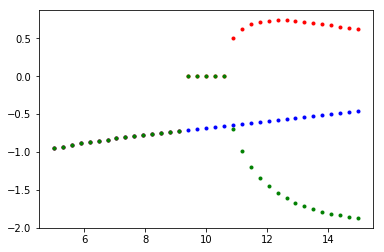

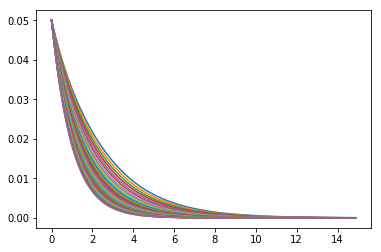

In [7]:
# insert your code here
fp1g = np.array([0,0])
fp2g = np.array([0.2, 0.1])
fp3g = np.array([0.4, 0.3])
for wEE in np.linspace(15, 5, num=35):

    fp1 = opt.root(wilson_cowan, np.array(fp1g)).x
    fp2 = opt.root(wilson_cowan, np.array(fp2g)).x
    fp3 = opt.root(wilson_cowan, np.array(fp3g)).x

    m1 = np.max(np.real(get_eig_Jacobian(fp1)))
    m2 = np.max(np.real(get_eig_Jacobian(fp2)))
    m3 = np.max(np.real(get_eig_Jacobian(fp3)))
    plt.plot(wEE, m1, '.b')
    plt.plot(wEE, m2, '.r')
    plt.plot(wEE, m3, '.g')

    fp1g = fp1
    fp2g = fp2
    fp3g = fp3
plt.show()

for wEE in np.linspace(15, 5, num=35):
    t = np.arange(0, 15, dt)
    E, I = simulate_wc(t, 0.05, 0.05)
    plt.plot(t, E)


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E3a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E3b.png)

**Exercise 4:** Now change the connectivity and external input parameters by executing the cell below.

In [11]:
# New recurrent connection strengths
wEE = 16
wEI = 12
wIE = 15
wII = 3

# New external input
I_ext = 1

Use ``get_E_nullcline`` and ``get_I_nullcline`` to plot the nullclines. How many fixed points do you see? Now plot some example trajectories with different initial conditions (in the 'expected output' I used $E_0 = 0,0.2,0.4$ and $I_0 = 0,0.2,0.4$, and an extra initial condition at $E_0=I_0= 0.25$). What attractors do you see? Test the stability of the limit cycle by plotting E and I vs t for an example initial condition that converges to the limit cycle (up to $t_{max}=50$). Finally, test the stability of the fixed point by calculating the eigenvalues.

/Users/yguan/miniconda3/envs/ccnss2018_students/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log


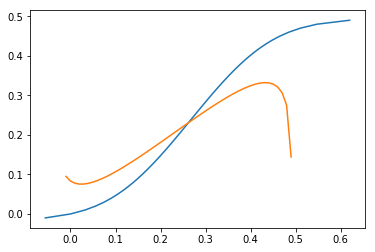

In [12]:
# insert your code her

ia = np.arange(-0.01, 0.45, 0.01)
ea = np.arange(-0.01, 0.7, 0.01)
    
plt.plot(get_I_nullcline(ia), ia)
plt.plot(ea, get_E_nullcline(ea))
plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E4a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E4b.png)

```
[0.10551462+1.63867543j 0.10551462-1.63867543j]
```

**Exercise 5:** Now plot the phase plane for $w_{II} =2,4,6$. This is the same kind of bifurcation that we saw with the FitzHugh Nagumo model (a 'Hopf' bifurcation). Plot the real part of the eigenvalues against $w_{11}$ between $0 \leq w_{11} \leq 6$ to see the transition from.

In [10]:
# insert your code here

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E5a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E5b.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E5c.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T3E5d.png)


**Bonus Exercise:** Ask Alex.